In [77]:
import numpy as np
!pip install control
from control import obsv
from control import ctrb

**Equations of motion**

Considered system is cartpole
\begin{equation}
\mathbf{\dot{X}} =
\begin{bmatrix}
0 & 1 & 0 & 0 \\
0 & -\frac{d}{m} & -\frac{mg}{M} & 0 \\
0 & 0 & 0 & 1 \\
0 & -s \frac{d}{ML} & -s \frac{(m+M)g}{ML} & 0
\end{bmatrix}
\begin{bmatrix}
x \\
\dot{x} \\
\theta \\
\dot{\theta}
\end{bmatrix}
+
\begin{bmatrix}
0 \\
\frac{1}{M} \\
0 \\
s \frac{1}{ML}
\end{bmatrix}
u
\end{equation}

Where $s=1$ means pendulum up position and $s=-1$ pendulum down position

y = Cx

* Checking observability

In [144]:
#system parameters:

m = 1.
M = 5.
L = 2.
g = -10.
d = 1.



s = -1 # s=-1 => pendulum down, s=1 => pendulum up

params = {}
params['m'] = m
params['M'] = M
params['L'] = L
params['g'] = g
params['d'] = d
params['s'] = s

A = np.array([
              [0.,1.,0.,0.], 
              [0., -d/M, -m*g/M, 0. ], 
              [0.,0.,0.,1.],
              [0.,-s*d/(M*L),-s*(m+M)*g/(M*L),0]])

B = np.array([0., 1/M, 0., s*1/(M*L)])
# B = B.T

#we only measure x(position of cart)
C = np.array([1,0,0,0])

C_modified = np.zeros((4,4))
C_modified[0,0] = 1

D = np.zeros(C.shape[0])

print(A)
print(B)
print(C)
print(D)

[[ 0.   1.   0.   0. ]
 [ 0.  -0.2  2.   0. ]
 [ 0.   0.   0.   1. ]
 [ 0.   0.1 -6.   0. ]]
[ 0.   0.2  0.  -0.1]
[1 0 0 0]
[0. 0. 0. 0.]


In [79]:
np.linalg.matrix_rank(obsv(A,C))

4

In [169]:
import scipy as sp
poles = np.array([-10.,-11.,-12.,-13.])

poles_placed = sp.signal.place_poles(A.T,C.reshape(1,-1).T,poles)
print(poles_placed.gain_matrix.shape)

observer_gains = poles_placed.gain_matrix[0]
print('observer gains matrix:')
print(observer_gains)

observer_gains_modified = np.zeros((4,4))
observer_gains_modified[0,:] = observer_gains
observer_gains_modified

(1, 4)
observer gains matrix:
[  45.8         775.83999997 2875.09999984 6229.57999951]


array([[  45.8       ,  775.83999997, 2875.09999984, 6229.57999951],
       [   0.        ,    0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ]])

In [170]:
#checking controllability
if np.linalg.matrix_rank(ctrb(A,B.reshape(-1,1))) == A.shape[0]:
    print('system is controllable')
else:
    print('system is not controllable')

#checking observability
if np.linalg.matrix_rank(obsv(A,C.reshape(1,-1))) == A.shape[0]:
    print('system is observable')
else:
    print('system is not observable')

#If system is observable, it means that measuring x(position of cart is enough to reconstruct all other states)

system is controllable
system is observable


* First i will make full state feedback via pole placement, system will become

\begin{equation}
\dot{x} = Ax + Bu \\
u = -Kx \\
\dot{x} = Ax - BKx = (A-BK)x
\end{equation}

Pole placement's task it to make this system stable by making real part of it's eigenvalues negative

In [172]:
import scipy as sp
poles = np.array([-1.,-1.1,-1.2,-1.3])
poles_placed = sp.signal.place_poles(A,B.reshape(-1,1),poles)
print(poles_placed.gain_matrix.shape)


gains = poles_placed.gain_matrix
print('gain matrix:')
print(gains)

(1, 4)
gain matrix:
[[  1.716   5.026 -15.668 -33.948]]


In [173]:
def sys_ode_controlled(state,t,params):
    m = params['m']
    M = params['M']
    L = params['L']
    g = params['g']
    d = params['d']
    s = params['s']


    #state = [x,dx,theta,dtheta]
    x,dx,theta,dtheta = state

    Sy = np.sin(theta)
    Cy = np.cos(theta)

    D = m*L*L*(M+m*(1-Cy**2))

    u = pole_control(state,gains)
    # print(u)
    #dstate = [dx,ddx,dtheta,ddtheta]

    ddx = (1/D)*(-m**2*L**2*g*Cy*Sy + m*L**2*(m*L*dtheta**2*Sy - d*dx)) + m*L*L*(1/D)*u

    ddtheta = (1/D)*((m+M)*m*g*L*Sy - m*L*Cy*(m*L*dtheta**2*Sy - d*dx)) - m*L*Cy*(1/D)*u

    # print(dx,ddx,dtheta,ddtheta)
    # dstate = np.concatenate((dx,ddx,dtheta,ddtheta))
    dstate = dx,ddx,dtheta,ddtheta

    return dstate

In [174]:
def pole_control(x,gains):
    #u = -Kx
    x_d = [0.,0.,0.,0.]
    u = np.dot(gains,(x_d-x))
    return u

In [175]:
from scipy.integrate import odeint

# Integration
t0 = 0 # Initial time 
tf = 10 # Final time
N = 1E4 # Numbers of points in time span
t = np.linspace(t0, tf, int(N)) # Create time span

x0 = np.array([1.,0.,np.pi/100.,0.])
q_sol = odeint(sys_ode_controlled, x0, t, args=(params,))

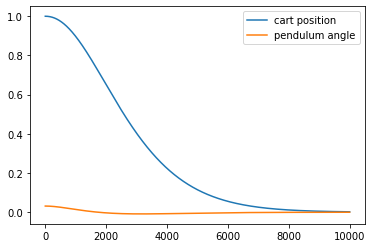

In [176]:
import matplotlib.pyplot as plt

x = q_sol[:,0]
dx = q_sol[:,1]
theta = q_sol[:,2]
dtheta = q_sol[:,3]

t = np.arange(len(x))

plt.plot(t,x,label='cart position')
plt.plot(t,theta,label='pendulum angle')
plt.legend()
plt.show()

* Observer design(luenberger observer):

\begin{equation}
\dot{\hat{x}} = A\hat{x} + Bu + L(y-\hat{y})\\
\hat{y} = C\hat{x} + Du
\end{equation}

Estimation error may be described as:

\begin{equation}
\dot{e} = \dot{x} - \dot{\hat{x}} = Ax + Bu - A\hat{x} - Bu - L(y-\hat{y}) = A(x-\hat{x}) - L(y - \hat{y}) = A(x-\hat{x}) - L(Cx + Du - C\hat{x} - Du) = A(x-\hat{x}) - LC(x-\hat{x}) \\
\dot{e} = (A-LC)(x-\hat{x}) = (A-LC)e
\end{equation}

This is close to what we have in full state feedback 
\begin{equation}
\dot{x} = Ax + Bu, \ u=-Kx \\
\dot{x} = (A-BK)x
\end{equation}

We want matrix (A-LC) to have negative eigenvalues, to make it stable(i.e. to make it converge to some stable point and not diverge). We can rewrite (A-LC):

\begin{equation}
(A-LC)x = I \lambda x \\
(I \lambda - (A-LC))x = 0 \\ 
\end{equation}

System of equations, described above will have single solution if $det(I \lambda - (A-LC)) \neq 0, x=0$. Eigenvectors does not exist in such case. For them to exist $det(I \lambda - (A-LC)) = 0$. On equation below determinant is defined by $|matrix|$

\begin{equation}
|(I \lambda - (A-LC))| = 0 \\
|(I \lambda)^T - (A-LC)^T| = 0 \\
|I \lambda - (A^T - C^TL^T)| = 0
\end{equation}

Equation above is written in same way as equation for pole placement in full state feedback, which is $|\lambda I - (A-BK) = 0|$. 

It possible to design observer gains using same pole placement method, but instead of A and B, we will use $A^T$ and $C^T$.

* Control design with observer

We will simulate original system and observer system in parallel:
\begin{equation}
\dot{x} = Ax - BK\hat{x} \\
\dot{\hat{x}} = A \hat{x} - BK\hat{x} + L(Cx-C\hat{x}) \\
\end{equation}

Resulting state space representation will be:
\begin{equation}
\begin{bmatrix}
\dot{x} \\
\dot{\hat{x}}
\end{bmatrix}
=
\begin{bmatrix}
A & -BK \\
LC & A-BK-LC
\end{bmatrix}
\begin{bmatrix}
x \\
\hat{x}
\end{bmatrix}
\end{equation}

K and C can were chosen by pole placement

In [181]:
import scipy as sp
poles = np.array([-1.,-1.1,-1.2,-1.3])
poles_placed = sp.signal.place_poles(A.T,C.reshape(1,-1).T,poles)
print(poles_placed.gain_matrix.shape)

observer_gains = poles_placed.gain_matrix[0]
print('gain matrix:')
print(gains)

(1, 4)
gain matrix:
[[  1.716   5.026 -15.668 -33.948]]


In [215]:
def pole_control(x,gains):
    #u = -Kx
    x_d = np.array([0.,0.,0.,0.],dtype='float64')
    u = np.dot(gains,(x_d-x))
    return u

In [216]:
def sys_ode_observed(full_state,t,params):
    m = params['m']
    M = params['M']
    L = params['L']
    g = params['g']
    d = params['d']
    s = params['s']

    #state = [x,dx,theta,dtheta]

    state = full_state[:4]
    state_hat = full_state[4:]

    x,dx,theta,dtheta = state
    x_hat,dx_hat,theta_hat,dtheta_hat = state_hat

    u = pole_control(state_hat,gains)
    # u = 0
    # print(u)

    dstate = np.dot(A,state) + B*u

    dstate_hat = np.dot(A,state_hat) + B*u + np.dot(np.dot(observer_gains.T,C),(state-state_hat))

    return np.concatenate((dstate,dstate_hat))


In [221]:
def sys_ode_observed_nonlinear(full_state,t,params):
    m = params['m']
    M = params['M']
    L = params['L']
    g = params['g']
    d = params['d']
    s = params['s']

    #state = [x,dx,theta,dtheta]

    state = full_state[:4]
    state_hat = full_state[4:]

    x,dx,theta,dtheta = state
    x_hat,dx_hat,theta_hat,dtheta_hat = state_hat

    u = pole_control(state_hat,gains)
    # u = 0
    # print(u)

    '''Actual system'''
    Sy = np.sin(theta)
    Cy = np.cos(theta)

    D = m*L*L*(M+m*(1-Cy**2))

    ddx = (1/D)*(-m**2*L**2*g*Cy*Sy + m*L**2*(m*L*dtheta**2*Sy - d*dx)) + m*L*L*(1/D)*u
    ddtheta = (1/D)*((m+M)*m*g*L*Sy - m*L*Cy*(m*L*dtheta**2*Sy - d*dx)) - m*L*Cy*(1/D)*u

    '''Observer'''

    Sy_hat = np.sin(theta_hat)
    Cy_hat = np.cos(theta_hat)

    D_hat = m*L*L*(M+m*(1-Cy_hat**2))

    ddx_hat = (1/D_hat)*(-m**2*L**2*g*Cy_hat*Sy_hat + m*L**2*(m*L*dtheta_hat**2*Sy_hat - d*dx)) + m*L*L*(1/D_hat)*u
    ddtheta_hat = (1/D_hat)*((m+M)*m*g*L*Sy_hat - m*L*Cy_hat*(m*L*dtheta_hat**2*Sy - d*dx_hat)) - m*L*Cy*(1/D_hat)*u

    dstate = np.array([dx,ddx,dtheta,ddtheta],dtype='float64')

    dstate_hat = np.array([dx_hat,ddx_hat,dtheta_hat,ddtheta_hat],dtype='float64')

    dstate_hat += np.dot(np.dot(observer_gains.T,C),(state-state_hat))

    return np.concatenate((dstate,dstate_hat))


In [222]:
from scipy.integrate import odeint

# Integration
t0 = 0 # Initial time 
tf = 20 # Final time
N = 1E4 # Numbers of points in time span
t = np.linspace(t0, tf, int(N)) # Create time span

x0 = np.array([1.,0.,np.pi/100,0.,0.,0.,0.,0.],dtype='float64')
q_sol = odeint(sys_ode_observed_nonlinear, x0, t, args=(params,))
print(q_sol.shape)

(10000, 8)


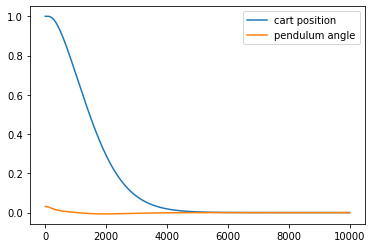

In [223]:
import matplotlib.pyplot as plt

x = q_sol[:,0]
dx = q_sol[:,1]
theta = q_sol[:,2]
dtheta = q_sol[:,3]

x_hat = q_sol[:,4]
dx_hat = q_sol[:,5]
theta_hat = q_sol[:,6]
dtheta_hat = q_sol[:,7]


t = np.arange(len(x))

plt.plot(t,x,label='cart position')
plt.plot(t,theta,label='pendulum angle')
plt.legend()
plt.show()

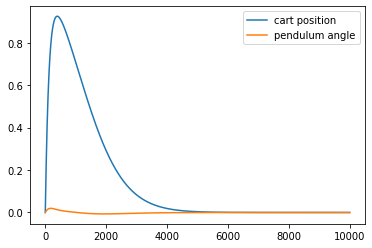

In [224]:
plt.plot(t,x_hat,label='cart position')
plt.plot(t,theta_hat,label='pendulum angle')
plt.legend()
plt.show()

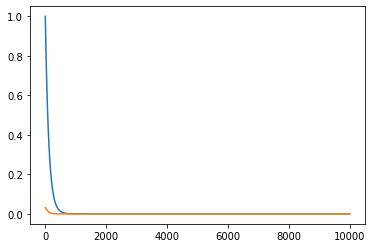

In [225]:
x_error = x-x_hat
theta_error = theta - theta_hat
plt.plot(t,x_error,label='error in cart position')
plt.plot(t,theta_error,label='error in pendulum angle')